## Base encoder architecture

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)    
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        'take in and process masked src and target sequences'
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [3]:
class Generator(nn.Module):
    'define standard linear + softmax generation step'
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Stacking things up

In [4]:
def clones(module, N):
    'produce N identical layers'
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [121]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        #print(x)
        #print(type(x))
        #print(x.shape)
        #mean = np.mean(x)
        #std = np.std(x)
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [122]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [123]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [124]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [125]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [126]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

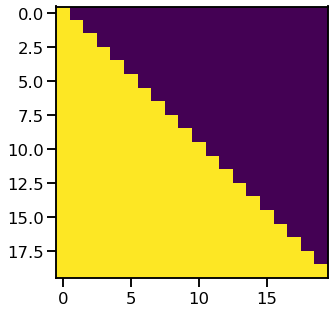

In [127]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

In [128]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [129]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)

In [130]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [131]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [132]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(1000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

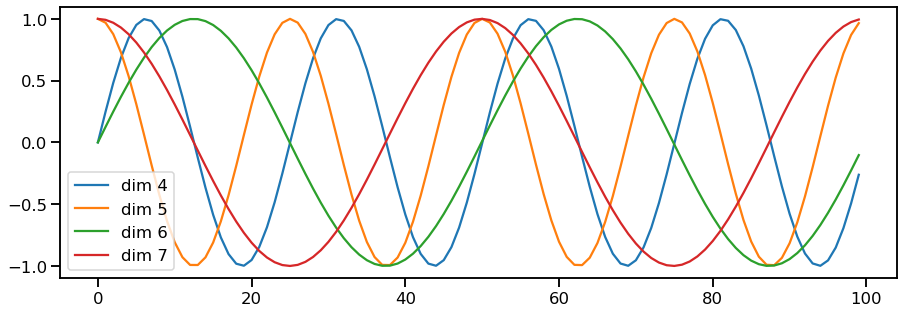

In [133]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(['dim %d'%p for p in [4, 5, 6, 7]])
plt.show()

In [134]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## Training

In [135]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        #print(tgt.shape, pd.shape)
        tgt_mask = (tgt != pad).unsqueeze(-2)
        #print(tgt_mask.shape)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [136]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch step: ", i, " Loss: ", loss/batch.ntokens, " Tokens per sec: ", tokens/elapsed)
            start = time/time()
            tokens = 0
    return total_loss / total_tokens

In [137]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

# Optimizer

In [138]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.otptimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size **(-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

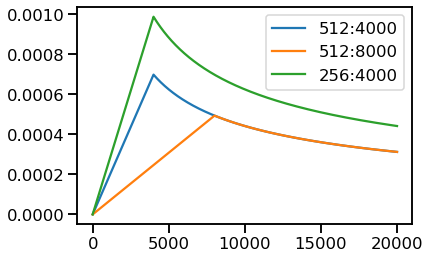

In [139]:
opts = [NoamOpt(512, 1, 4000, None),
      NoamOpt(512, 1, 8000, None),
      NoamOpt(256, 1, 4000, None)]

plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(['512:4000', "512:8000", "256:4000"])

# Regularization

In [140]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing/ (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
            self.true_dist = true_dist
            return self.criterion(x, Variable(true_dist, requires_grad=False))

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


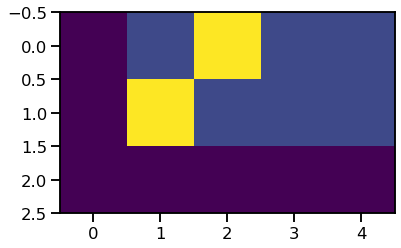

In [141]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
        Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)

In [142]:
"""crit = LabelSmoothing(5, 0, 0.1)

def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d], ])
    return crit(Variable(predict.log()), Variable(torch.tensor([1], dtype=torch.long))).data[0]

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])"""

'crit = LabelSmoothing(5, 0, 0.1)\n\ndef loss(x):\n    d = x + 3 * 1\n    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d], ])\n    return crit(Variable(predict.log()), Variable(torch.tensor([1], dtype=torch.long))).data[0]\n\nplt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])'

In [143]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download fr

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/fr_core_news_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [114]:
from torchtext import data, datasets
import spacy

In [115]:
spacy_en = spacy.load('en')
spacy_fr = spacy.load('fr')

print(spacy_fr)
print('\n')
print(spacy_en)

In [32]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = '<blank>'

SRC = data.Field(tokenize=tokenize_en, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_fr, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
#dataset = datasets.IWSLT.splits(exts=('.fr', '.en'), fields=(SRC, TGT), filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
train, val, test = datasets.IWSLT.splits(exts=('.fr', '.en'), fields=(SRC, TGT), filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 2

downloading fr-en.tgz


fr-en.tgz: 100%|██████████| 25.7M/25.7M [00:01<00:00, 15.9MB/s]


.data/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2012.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.dev2010.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2013.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.fr.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2011.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2014.fr-en.en.xml
.data/iwslt/fr-en/IWSLT16.TED.tst2010.fr-en.en.xml
.data/iwslt/fr-en/train.tags.fr-en.fr
.data/iwslt/fr-en/train.tags.fr-en.en


In [144]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [145]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(sorted(p, key=self.sort_key), self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size, self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))
                
def rebatch(pad_idx, batch):
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)
            

# Multi GPU Training

In [149]:
class MultiGPULossCompute:
    def __init__(self, generator, criterion, devices, opt=None, chunk_size = 5):
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.optimizer = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, devices=self.devices)
        out_scatter = nn.parallel.scatter(targets, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, target_gpus=self.devices)
        
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            out_column = [[Variable(o[:, i:i+chunk_size].data, requires_grad=self.optimizer is not None)] for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)
            
            y = [(g.contiguous().view(-1, g.size(-1)), t[:, i:i+chunk_size].contiguous().view(-1)) for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(generator, out_column)
            
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]
            
            if self.optimizer is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())
                    
        if self.optimizer is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            
            o1.backward(gradient=o2)
            self.optimizer.step()
            self.optimizer.optimizer.zero_grad()
        return total * normalize

# Training the system

In [ ]:
if True:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), model_par, MultiGPULossCompute(model.generator, criterion, devices=devices, opt=model_opt))
        
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), model_par, MultiGPULossCompute(model.generator, criterion, devices=devices, opt=None))
        print(loss)
else:
    model = torch.load('iwslt.pt')

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi['<blank>']).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, max_len=60, start_symbol=TGT.vocab.stoi['<s>'])
    
    print('Translation: ', end='\t')
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == '</s>': break
        print(sym, end = " ")
        
    print()
    print('Target: ', end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end=" ")
    print('\n')
    print('Target:\n')
    for i in range(1, batch.tgr.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == '</s>': break
        print(sym, end = " ")
        print('\n')
        break

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt
model, SRC, TGT = torch.load("en-de-model.pt")
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)